In [1]:
import os

import joblib
import numpy as np
import shap
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import attack as wfpattack
from argparser import shap_parser
from dataset import get_ds

In [2]:
# prase arguments
# args = shap_parser().parse_args()
random_seed = 11
ds_root = "./data"
cache_root = "./data/cache"
# attack_name = args.attack
# note = args.note
# train = args.train
# dataset = args.dataset
# model_epoch = args.epoch
attack_name = "RF"
note = "base"
train = "undefend"
dataset = "undefend"
model_epoch = 0
model_dir = f"data/dump/{note}/{attack_name}/train_{dataset}_d{train}"
assert os.path.exists(model_dir), model_dir

print("Loading test dataset...")
ds = get_ds("ours")
ds.load_defended(train)
num_classes = ds.num_classes()
attack: wfpattack.DNNAttack = wfpattack.get_attack(attack_name)(10000, num_classes, 3)


ds_len = len(ds)

train_slice, test_slice = train_test_split(
    [i for i in range(ds_len)], test_size=0.2, random_state=random_seed
)


print("Preparing data...")

data = ds.get_cached_data(attack)


attack.init_model()
print("Evaluating...")
result = attack.evaluate(
    data["traces"],
    data["labels"],
    load_dir=model_dir,
    epoch=model_epoch,
    data=True,
)
assert isinstance(result, tuple) and len(result) == 3
metrics_dict, y_true, y_pred = result
y_true = y_true.argmax(axis=1)
y_pred = y_pred.argmax(axis=1)

train_features, train_labels, train_pred = (
    data["traces"][train_slice],
    y_true[train_slice],
    y_pred[train_slice],
)
test_features, test_labels, test_pred = (
    data["traces"][test_slice],
    y_true[test_slice],
    y_pred[test_slice],
)
good_features = test_features[test_labels == test_pred]
good_labels = test_labels[test_labels == test_pred]

Loading test dataset...
Try to load cached cell level data from data/cell_level/ours.npz if existed
Try to load cached undefend defended data from data/defended/ours/undefend_cell_level_334748706e754c84084d1402aab45a49.npz if existed
Preparing data...
Try to load cached processed data from data/cache/ours_RF_undefend_7668e723c0c41931e186c2ccc27cdaaa.pkl if existed


Preprocessing RF features: 100%|██████████| 10000/10000 [00:07<00:00, 1420.38it/s]


Saving processed data to data/cache/ours_RF_undefend_7668e723c0c41931e186c2ccc27cdaaa.pkl
Evaluating...


In [ ]:
device = attack.device
model = attack.model
model.eval()

In [41]:
idx = np.random.randint(good_labels.shape[0])
print({idx=})
label = good_labels[idx]
input = good_features[idx].unsqueeze(0).to(attack.device)

95

In [40]:
# shap
bg_features = []
for label in range(num_classes):
    features = good_features[good_labels == label]
    bg_features.append(features[:2])
    # test_traces[label] = traces[2:]
bg_features = torch.cat(bg_features, dim=0)
explainer = shap.DeepExplainer(model, bg_features.to(device))
shap_value = explainer.shap_values(input, ranked_outputs=1, check_additivity=False)

# IntegratedGradients
from captum.attr import IntegratedGradients

integrated_gradients = IntegratedGradients(attack.model)
attributions_ig = (
    integrated_gradients.attribute(input, target=31, n_steps=200).squeeze().cpu().detach().numpy()
)

([array([[[[ 6.44095189e-06,  1.17870923e-05, -1.15248549e-05, ...,
             1.18708705e-08, -2.89150694e-06, -1.77482143e-03],
           [-4.36257505e-06,  4.43200815e-06,  1.15236730e-06, ...,
             6.83538892e-05,  1.61654680e-05,  9.43537278e-04]]]])],
 tensor([[31]], device='cuda:3'))

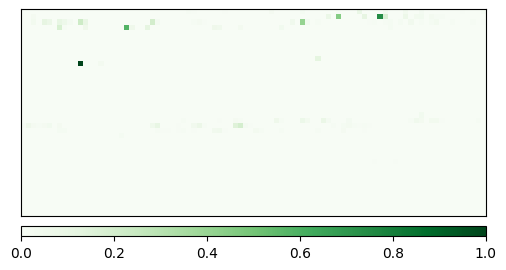

In [29]:
from captum.attr import visualization as viz

_ = viz.visualize_image_attr(
    attributions_ig.squeeze().cpu().detach().numpy().reshape(40, 90, 1),
    method="heat_map",
    # cmap=default_cmap,
    show_colorbar=True,
    sign="positive",
    outlier_perc=1,
)

In [ ]:
for label in tqdm(range(num_classes)):
    features = test_features[test_labels == label]
    labels = test_labels[test_labels == label]
    pred = test_pred[test_labels == label]
    shap_values = explainer.shap_values(features.to(device))
    np.savez(
        f"data/shap/test-{label}",
        features=features,
        labels=labels,
        pred=pred,
        shap_values=shap_values,
    )
for label in tqdm(range(num_classes)):
    features = train_features[train_labels == label]
    labels = train_labels[train_labels == label]
    pred = train_pred[train_labels == label]
    shap_values = explainer.shap_values(features.to(device))
    np.savez(
        f"data/shap/train-{label}",
        features=features,
        labels=labels,
        pred=pred,
        shap_values=shap_values,
    )

In [ ]:
import os
import numpy as np


def read_npz(mode, label):
    data = np.load(f"data/shap/{mode}-{label}.npz")
    output_dir = f"data/shap/undefend/{mode}/{label}/"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    np.save(output_dir + "features", data["features"])
    np.save(output_dir + "labels", data["labels"])
    np.save(output_dir + "preds", data["pred"])
    shap_values = data["shap_values"]
    for i in range(len(shap_values)):
        np.save(output_dir + f"shap_values-{i}", shap_values[i])


from joblib import Parallel, delayed

for mode in ["train", "test"]:

    Parallel(n_jobs=20, verbose=10)(delayed(read_npz)(mode, label) for label in range(100))